In [1]:
#Imports
import pandas as pd
import os
import tensorflow as tf

from scipy.stats import ks_2samp
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

import sys  
sys.path.append("../../")  
from utils.models import *
from utils.datahandling import *
from utils.modelrunner import *

In [2]:
# Define constants and configurations
num_features = 7  # Number of features
sequence_length = 25
batch_size = 16
evaluation_interval = 168
mae_threshold = 0.1
ks_significance_level = 0.05

In [3]:
# Load data
num_users = 30

cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
df = pd.read_csv(cwd+'/data/3final_data/Final_PV_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Filter data for a specific period
start_date = df.index.min() + pd.DateOffset(years=1)
end_date = df.index.max()
df = df[(df.index >= start_date) & (df.index < end_date)]

df = min_max_scaling(df)
df.reset_index(inplace=True, drop=True)

df_array = []
for idx in range(num_users):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])

In [4]:
loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()

callbacks=[early_stopping, timing_callback, custom_callback]

custom_objects = {'EinsumLayer': EinsumLayer,'TopKLayer': TopKLayer,'ImportanceRegularizationLayer': ImportanceRegularizationLayer}

In [5]:
def load_and_compile_model(model_path, model_type, custom_objects=None):
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)
    model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)
    return model

def calculate_metrics(actual, predictions):
    return {
        'RMSE': np.sqrt(mean_squared_error(actual, predictions)),
        'MAE': mean_absolute_error(actual, predictions),
        'MSE': mean_squared_error(actual, predictions)
    }

def check_concept_drift(actual_interval, predicted_interval, previous_mae, mae_threshold, ks_significance_level, cd_mae_counter, cd_ks_counter):
   
    current_mae = mean_absolute_error(actual_interval, predicted_interval)
    
    if not np.isnan(previous_mae) and current_mae > previous_mae * (1 + mae_threshold):
        cd_mae_counter += 1

    ks_pvalue = ks_2samp(actual_interval, predicted_interval).pvalue
    if ks_pvalue < ks_significance_level:
        cd_ks_counter += 1 

    return cd_mae_counter, cd_ks_counter, current_mae

In [6]:
# Initialize DataFrame to store results
forecast_type = "PV"
columns = ['User', 'Round', 'CD_mae_count', 'CD_ks_count']
model_names = ['BiLSTM', 'CNN', 'Transformer', 'soft_dense', 'soft_bilstm', 'topk_dense', 'topk_bilstm']

for name in model_names:
    columns.extend([f'RMSE_{name}', f'MAE_{name}', f'MSE_{name}'])

results_df = pd.DataFrame(columns=columns)

num_rounds = 5
for round in range(num_rounds):
    for user_index, user_df in enumerate(df_array):
        
        print("Round ", round +1, "/ ", num_rounds, ", User ", user_index+1, " / ", num_users)

        model_paths = {
            'BiLSTM': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Benchmark/wandb/TS_LL_{forecast_type}_bilstm_u{user_index+1}_rd{round+1}.keras',
            'CNN': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Benchmark/wandb/TS_LL_{forecast_type}_cnn_u{user_index+1}_rd{round+1}.keras',
            'Transformer': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Benchmark/wandb/TS_LL_{forecast_type}_transformer_u{user_index+1}_rd{round+1}.keras',
            'soft_bilstm': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Moe/wandb/TS_LL_{forecast_type}_lstm_soft_moe_u{user_index+1}_rd{round+1}.keras',
            'soft_dense': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Moe/wandb/TS_LL_{forecast_type}_dense_soft_moe_u{user_index+1}_rd{round+1}.keras',
            'topk_bilstm': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Moe/wandb/TS_LL_{forecast_type}_lstm_topk_moe_u{user_index+1}_rd{round+1}.keras',
            'topk_dense': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Moe/wandb/TS_LL_{forecast_type}_dense_topk_moe_u{user_index+1}_rd{round+1}.keras'
        }
        models = {name: load_and_compile_model(path, name, custom_objects) for name, path in model_paths.items()}
               
        # Stream data simulation, initialization
        stream_data = user_df.values
        stream_buffer = []
        actual_values = []
        cd_mae_counter, cd_ks_counter = 0,0
        previous_mae_bilstm = np.NaN
        stream_predictions = {name: [] for name in model_names}
    
        # Enumerate through the data stream
        for idx, data in enumerate(stream_data):
            
            # Buffer: Append data (1 row is one array) to the buffer and pop oldest if sequence_length is surpassed.
            stream_buffer.append(data)
            
            # Check if we have enough data for a batch prediction
            if len(stream_buffer) >= batch_size + sequence_length - 1:
                # Prepare batch data for prediction
                batch_data = []
                for i in range(batch_size):
                    x_pred = np.array([stream_buffer[i:i+sequence_length-1]])
                    batch_data.append(x_pred)              
                
                # Convert list to numpy array for prediction
                batch_data = np.concatenate(batch_data, axis=0)  # Shape becomes (16, 24, 8)

                # Make predictions for each model
                for name, model in models.items():
                    predictions = model.predict(batch_data, callbacks=callbacks, verbose=0)
                    stream_predictions[name].extend(predictions[:, 0].tolist())

                # Append actual values for the batch
                actual_values.extend([d[0] for d in stream_buffer[-batch_size:]])
                # Clear the processed batch data from buffer
                del stream_buffer[:batch_size]

            # Check and evaluate at every evaluation_interval
            if (idx + 1) % evaluation_interval == 0 and len(actual_values) >= evaluation_interval:
                actual_interval = actual_values[-evaluation_interval:]
                predicted_interval = stream_predictions['BiLSTM'][-evaluation_interval:]  # Example for BiLSTM

                cd_mae_counter, cd_ks_counter, current_mae = check_concept_drift(
                    actual_interval, predicted_interval, previous_mae_bilstm, mae_threshold, ks_significance_level, cd_mae_counter, cd_ks_counter
                )
                                
                previous_mae_bilstm = current_mae   
                   
        # Calculate metrics for each model and append to DataFrame
        if actual_values:
            metrics_data = {'User': user_index+1, 'Round': round+1, 'CD_mae_count': cd_mae_counter, 'CD_ks_count': cd_ks_counter}
            for name in model_names:
                metrics_data.update({f'{metric}_{name}': value for metric, value in calculate_metrics(actual_values, stream_predictions[name]).items()})
            results_df.loc[len(results_df)] = metrics_data
           
results_df

Round  1 /  5 , User  1  /  30
Round  1 /  5 , User  2  /  30
Round  1 /  5 , User  3  /  30
Round  1 /  5 , User  4  /  30
Round  1 /  5 , User  5  /  30
Round  1 /  5 , User  6  /  30
Round  1 /  5 , User  7  /  30
Round  1 /  5 , User  8  /  30
Round  1 /  5 , User  9  /  30
Round  1 /  5 , User  10  /  30
Round  1 /  5 , User  11  /  30
Round  1 /  5 , User  12  /  30
Round  1 /  5 , User  13  /  30
Round  1 /  5 , User  14  /  30
Round  1 /  5 , User  15  /  30
Round  1 /  5 , User  16  /  30
Round  1 /  5 , User  17  /  30
Round  1 /  5 , User  18  /  30
Round  1 /  5 , User  19  /  30
Round  1 /  5 , User  20  /  30
Round  1 /  5 , User  21  /  30
Round  1 /  5 , User  22  /  30
Round  1 /  5 , User  23  /  30
Round  1 /  5 , User  24  /  30
Round  1 /  5 , User  25  /  30
Round  1 /  5 , User  26  /  30
Round  1 /  5 , User  27  /  30
Round  1 /  5 , User  28  /  30
Round  1 /  5 , User  29  /  30
Round  1 /  5 , User  30  /  30
Round  2 /  5 , User  1  /  30
Round  2 /  5 , Us

,User,Round,CD_mae_count,CD_ks_count,RMSE_BiLSTM,MAE_BiLSTM,MSE_BiLSTM,RMSE_CNN,MAE_CNN,MSE_CNN,...,MSE_soft_dense,RMSE_soft_bilstm,MAE_soft_bilstm,MSE_soft_bilstm,RMSE_topk_dense,MAE_topk_dense,MSE_topk_dense,RMSE_topk_bilstm,MAE_topk_bilstm,MSE_topk_bilstm
0,1,1,36,103,0.087976,0.048252,0.007740,0.250965,0.200918,0.062983,...,0.007826,0.093112,0.058020,0.008670,0.094010,0.055577,0.008838,0.098556,0.055811,0.009713
1,2,1,29,103,0.090813,0.048639,0.008247,0.263261,0.221011,0.069306,...,0.008718,0.089536,0.053629,0.008017,0.097011,0.065591,0.009411,0.101454,0.060273,0.010293
2,3,1,25,103,0.091188,0.046443,0.008315,0.275929,0.232712,0.076137,...,0.008995,0.095759,0.059984,0.009170,0.097546,0.061274,0.009515,0.095573,0.062139,0.009134
3,4,1,28,103,0.104095,0.059654,0.010836,0.260702,0.222577,0.067966,...,0.013668,0.092622,0.058483,0.008579,0.096575,0.061977,0.009327,0.106025,0.064569,0.011241
4,5,1,31,103,0.089209,0.057607,0.007958,0.276576,0.233655,0.076494,...,0.008971,0.093021,0.056008,0.008653,0.092764,0.058002,0.008605,0.093585,0.057381,0.008758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,26,5,31,103,0.092090,0.050292,0.008481,0.270030,0.217431,0.072916,...,0.007808,0.100314,0.060009,0.010063,0.089618,0.051185,0.008031,0.094988,0.053101,0.009023
146,27,5,35,103,0.091116,0.049660,0.008302,0.271184,0.224442,0.073540,...,0.008689,0.093071,0.067326,0.008662,0.089252,0.054643,0.007966,0.088059,0.051356,0.007754
147,28,5,27,103,0.128772,0.076962,0.016582,0.256463,0.206452,0.065773,...,0.006143,0.085659,0.053086,0.007337,0.079752,0.045888,0.006360,0.072410,0.039686,0.005243
148,29,5,34,103,0.147472,0.077130,0.021748,0.254095,0.200566,0.064564,...,0.008597,0.098472,0.060091,0.009697,0.097469,0.056144,0.009500,0.097795,0.054354,0.009564


In [7]:
predictions_df = pd.DataFrame.from_dict(stream_predictions)

predictions_df.to_csv(f'results/Predictions_DS_LL_{forecast_type}_Forecasting.csv')  
results_df.to_csv(f'results/Results_DS_LL_{forecast_type}_Forecasting.csv')  

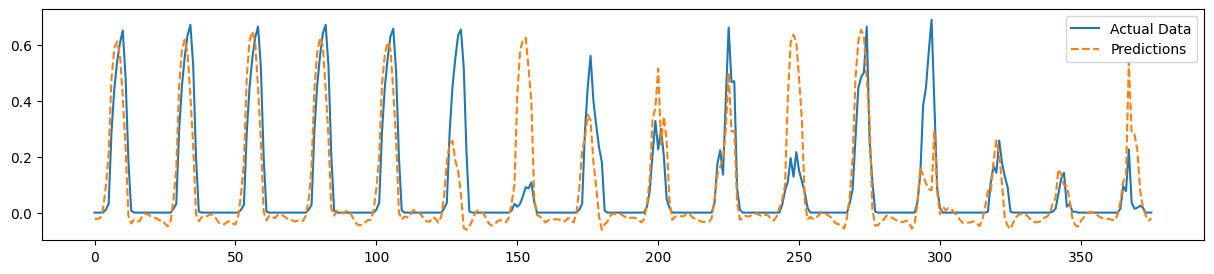

In [8]:
# Plotting to visualize the results
plt.figure(figsize=(15, 3))
plt.plot(df['User1'][124:500].values, label='Actual Data')
plt.plot(stream_predictions["soft_bilstm"][124:500], label='Predictions', linestyle='dashed')
plt.legend()
plt.show()